#Introducción
---
TFM: Aplicación de ciencia de datos en el sector de producción animal para la predicción y explicación de óptimos en ganado porcino.

*Titulo*: **Evaluación del Modelo Final**

*Autor*: **Jose Eduardo Cámara Gómez**

---

## Importar paquetes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

In [2]:
from google.colab import files
# Cargamos el fichero del dataset gmd_02.csv
uploaded = files.upload()
# Leemos el fichero csv con los datos
df = pd.read_csv('gmd_02.csv', sep=';')
# Revisar la raza si se agrupan las razas con menos ocurrencias
agrupar_razas = {93 : 93, 85 : 93, 90 : 93, 95 : 93, 94 : 93, 82 : 93, 80 : 80, 96 : 80, 88 : 88, 0 : 0, 23 : 0,
                 84 : 0, 66 : 0, 18 : 0, 68 : 88, 7 : 7, 89 : 7, 65 : 7, 15 : 15, 97 : 7, 69 : 69, 81 : 81}
df.replace({'ct_raza' : agrupar_razas}, inplace=True)
df["bajas"] = df["NumBajas"] / (df["NumAnimales"] * df["DiasMedios"])
# Convertimos los tipos
df["ct_integra"] = df["ct_integra"].astype("category")
#df["ct_tipo"] = df["ct_tipo"].astype("category")
df["ct_raza"] = df["ct_raza"].astype("category")
df["ct_fase"] = df["ct_fase"].astype("category")
df['EntradaInicial']= pd.to_datetime(df['EntradaInicial'])
df['EntradaFinal']= pd.to_datetime(df['EntradaFinal'])
df["na_rega"] = df["na_rega"].astype("category")
df["NumBajas"] = df["NumBajas"].astype("int64")
df["gr_codpos"] = df["gr_codpos"].astype("category")
df["gr_poblacion"] = df["gr_poblacion"].astype("category")
df["na_nombre2"] = df["na_nombre2"].astype("category")

# Funcion para convertir en One Hot Encoding
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)
# Cargamos las variables objetivo y las usadas (15 variables seleccionadas, una de ellas categórica con 8 valores).
y = df['GMD']
x0 = df[['ct_integra','ct_tipo', 'ct_raza', 'IncPeso', 'NumAnimales', 'na_rega', 
         'PesoEntMedio', 'PesoRecMedio', 'bajas', 'GPS_Longitud', 'GPS_Latitud', 
         'semanaEntrada', 'añoEntrada', 'PorcHembras', 'PiensoCerdaDia']]
features_to_encode = ['ct_raza']   # , 'na_rega']
x1 = x0.copy()
x1.drop(['ct_integra','na_rega'], inplace=True, axis=1)
for feature in features_to_encode:
    x1 = encode_and_bind(x1, feature)

Saving gmd_02.csv to gmd_02.csv


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
X_train, X_test, y_train, y_test = train_test_split(x1, y, test_size = 0.2, random_state = 123)
# Vemos de escalar las variables para que no se vean influenciadas por los outliers.
scaler = RobustScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

## Cargamos el mejor modelo

In [4]:
import lightgbm as lgb
# Cargamos el fichero del modelo lightgbm.model.txt
uploaded = files.upload()
model2 = lgb.Booster(model_file='lightgbm.model.txt')

y_pred = model2.predict(X_test_s)

Saving lightgbm.model.txt to lightgbm.model.txt


# Comprobar criterios de Éxito

## El 95% de los datos estimados de GMD se desvíe menos del 10%.

In [5]:
# Vemos las diferencias los valores redichos
diferencias = abs(y_pred - y_test)
# Vemos las filas de test que se desvían más del 10% (diferencia >= 0.085).
dif_10 = diferencias[lambda x: x>=0.085]
print("Hay",len(dif_10),"predicciones que fallan por encima del 10%, siendo un",round(100*len(dif_10)/len(diferencias),2),"% del total")

Hay 16 predicciones que fallan por encima del 10%, siendo un 1.52 % del total


## Estimación de número de animales por semana 

In [6]:
# Estimamos el valor de GMD para todos los datos y los reagrupamos en un Datafreme llamado datos
y_pred_tst = model2.predict(X_test_s)
y_pred_tr = model2.predict(X_train_s)
train = X_train.copy(); train["GMD_real"] = y_train; train["GMD_pred"] = y_pred_tr
test = X_test.copy(); test["GMD_real"] = y_test; test["GMD_pred"] = y_pred_tst
datos = pd.concat([train,test], axis=0)
# Calculamos los días de recogida con ambos GMD y la diferencia
datos["semanas_rec_real"] = (round((datos["IncPeso"] / datos["GMD_real"]) / 7,0)) + datos["semanaEntrada"]
datos["semanas_rec_pred"] = (round((datos["IncPeso"] / datos["GMD_pred"]) / 7,0)) + datos["semanaEntrada"]

In [8]:
# Seleccionamos los datos con los que hacer la comparación, un intervalo de 10 semanas para el final de lo datos (248 contratos y 415658 animales).
datos_sel = datos[((datos.añoEntrada==2021)&(datos.semanas_rec_real>=30)&(datos.semanas_rec_real<40)&(datos.semanas_rec_pred>=30)&(datos.semanas_rec_pred<40))]
print("Total animales seleccionados",datos_sel.NumAnimales.sum(),"animales")

Total animales seleccionados 415658 animales


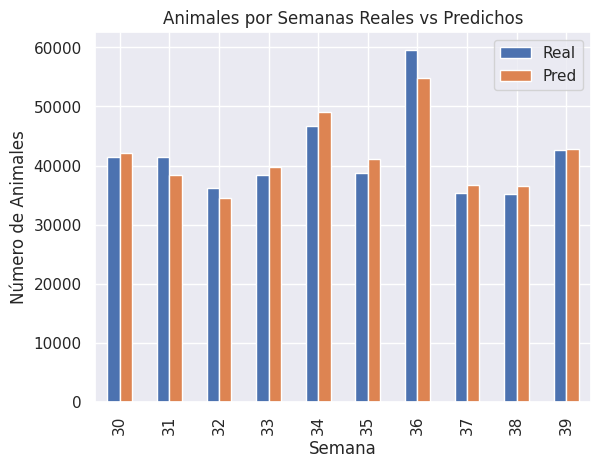

In [9]:
# Agrupamos los animales por semanas
animSemanaReal = datos_sel.groupby(["semanas_rec_real"])["NumAnimales"].sum()
animSemanaPred = datos_sel.groupby(["semanas_rec_pred"])["NumAnimales"].sum()
# Juntamos en un mismo Dataframe
animSemanas = pd.concat([animSemanaReal,animSemanaPred], axis=1)
animSemanas.columns = ["Real", "Pred"]; animSemanas.index = animSemanas.index.astype("int")
# Graficamos los resultados de la agrupación de animales real frente a la Predicha
animSemanas.plot(kind="bar")
plt.title("Animales por Semanas Reales vs Predichos")
plt.ylabel("Número de Animales")
plt.xlabel("Semana")
plt.show()

La media de la diferencia de animales es 4.382367 %


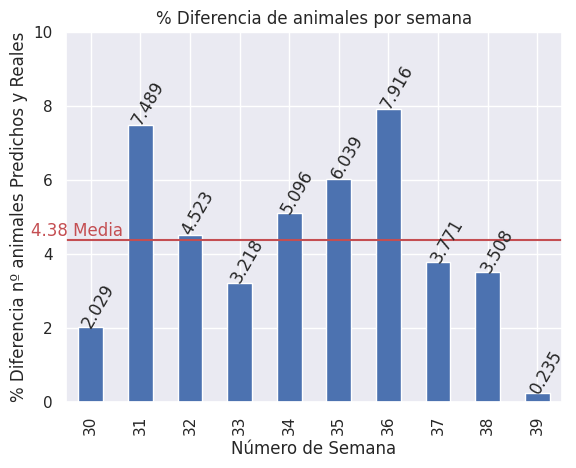

In [23]:
# Vemos las diferencias por semanas
dif = round(100 * abs(animSemanas["Real"] - animSemanas["Pred"]) / animSemanas["Real"],5)
print("La media de la diferencia de animales es",dif.mean(),"%")
ax = dif.plot(kind="bar")
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=60)
ax.axhline(dif.mean(), c="r")
ax.text(-1.2, dif.mean()+0.1, str(round(dif.mean(),2))+" Media", c="r")
plt.title("% Diferencia de animales por semana")
plt.xlabel("Número de Semana")
plt.ylabel("% Diferencia nº animales Predichos y Reales")
plt.ylim((0,10))
plt.show()

In [24]:
datos.to_csv("gmd_03.csv")